In [5]:
import pybma

import matplotlib.pyplot as plt
import numpy as np

In [10]:
m = pybma.load_model("../models/ToyModelUnstable.json")
qn = pybma.model_to_qn(m)
p = pybma.check_stability(qn)

print("###Unstable model###")
print(p)

#knock out a variable
m['Model']['Variables'][0]['Formula'] = "0"
qn = pybma.model_to_qn(m)
pko = pybma.check_stability(qn)

print("###Modified Model###")
print(pko)

###Unstable model###
{'ProofProgression': {'stable': False, 'history': [(3, {1: (0, 4), 2: (0, 4), 3: (0, 4)}), (2, {1: (0, 4), 2: (0, 4), 3: (0, 4)}), (1, {1: (0, 4), 2: (0, 4), 3: (0, 4)}), (0, {1: (0, 4), 2: (0, 4), 3: (0, 4)})]}, 'CounterExample': {'Result': 'CExCycle', 'Example': {'1^0': 2, '1^1': 1, '1^2': 2, '1^3': 2, '1^4': 3, '1^5': 2, '1^6': 2, '2^0': 2, '2^1': 2, '2^2': 1, '2^3': 2, '2^4': 2, '2^5': 3, '2^6': 2, '3^0': 3, '3^1': 2, '3^2': 2, '3^3': 1, '3^4': 2, '3^5': 2, '3^6': 3}}}
###Modified Model###
{'ProofProgression': {'stable': True, 'history': [(4, {1: (0, 0), 2: (0, 0), 3: (0, 0)}), (3, {1: (0, 0), 2: (0, 0), 3: (0, 0)}), (2, {1: (0, 0), 2: (0, 0), 3: (0, 0)}), (1, {1: (0, 0), 2: (0, 0), 3: (0, 4)}), (0, {1: (0, 0), 2: (0, 4), 3: (0, 4)})]}, 'CounterExample': None}


In [11]:
#functions to process proof progressions to turn them into a heatmap

def singleton(a):
    if a[0]==a[1]:
        return 1
    else:
        return 0
    
def timeHM(timepoint):
    state = []
    for var in timepoint.keys():
        state.append(singleton(timepoint[var]))
    return state

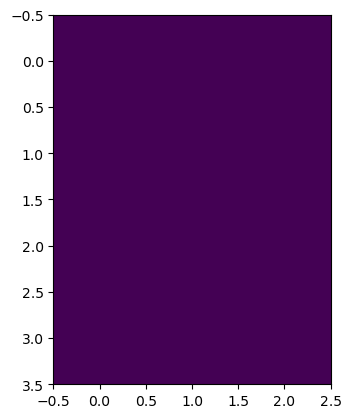

In [12]:
    
progression = p["ProofProgression"]["history"]
progressionHM = [ timeHM(time[1]) for time in progression ]
plt.imshow(progressionHM, cmap='viridis', interpolation='nearest')

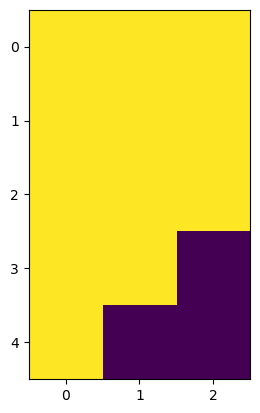

In [9]:
progression = pko["ProofProgression"]["history"]
progressionHM = [ timeHM(time[1]) for time in progression ]
plt.imshow(progressionHM, cmap='viridis', interpolation='nearest')